# Introducción a PyTorch


Este notebook comienza con una introducción a PyTorch, una biblioteca muy popular en el campo del *deep learning*.
Retomaremos la red neuronal del notebook anterior e implementaremos su funcionalidad en PyTorch.


In [2]:
import random
import numpy as np 
import matplotlib.pyplot as plt

# Import classiques des utilisateurs de pytorch 
import torch 
import torch.nn as nn
import torch.nn.functional as F

### Conjunto de datos y DataLoader


Vamos a reconstruir un conjunto de datos de manera similar al notebook anterior. Además, debemos convertir las variables $X$ e $y$ en tensores (equivalente a *Value* en micrograd).


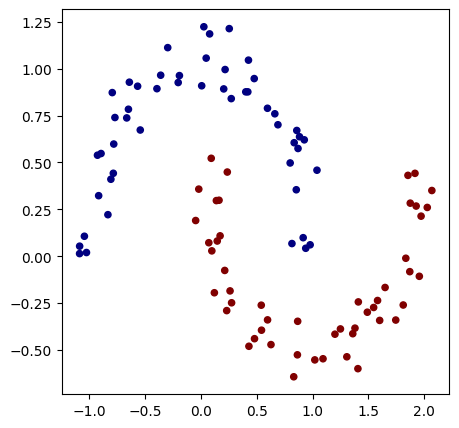

In [5]:
# Initialisation du dataset 
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.1)
X=torch.tensor(X).float() # Conversion en tensor pytorch (équivalent de Value)
y=torch.tensor(y).float() # Conversion en tensor pytorch
y = y*2 - 1 

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

Ahora, utilicemos las funcionalidades de PyTorch para crear nuestro conjunto de datos y nuestro *DataLoader*.
El conjunto de datos agrupa simplemente las entradas y las etiquetas, mientras que el *DataLoader* facilita el uso del descenso de gradiente estocástico al proporcionar directamente un *mini-batch* de datos aleatorios extraídos del conjunto (el *DataLoader* actúa como un iterador).


In [6]:
from torch.utils.data import TensorDataset, DataLoader
# Création d'un dataset qui stocke les couples de valeurs X,y
dataset = TensorDataset(X, y)

# Création d'un dataloader qui permet de gérer automatiquement les mini-batchs pour la descente de gradient stochastique. 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Para aprender más sobre el conjunto de datos y el *DataLoader*, puedes consultar la [documentación de PyTorch](https://pytorch.org/docs/stable/index.html).


### Construcción del modelo


Ahora, construyamos nuestro modelo con 2 capas ocultas.

Para ello, crearemos una clase `MLP` que herede de la clase [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
Luego, construimos las capas de la red utilizando la función [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)(`in_features`, `out_features`), que crea una capa completamente conectada que recibe `in_features` como entrada y devuelve `out_features` como salida.
Se trata de una capa compuesta por `out_features` neuronas conectadas a `in_features` entradas.


In [7]:
class mlp(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(2,16) # première couche cachée 
    self.fc2=nn.Linear(16,16) # seconde couche cachée 
    self.fc3=nn.Linear(16,1) # couche de sortie
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.fc1(x)) # le F.relu permet d'appliquer la fonction d'activation ReLU sur la sortie de notre couche 
    x=F.relu(self.fc2(x))
    output=self.fc3(x)
    return output

In [8]:
model = mlp() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

mlp(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
Nombre de paramètres 337


Observamos que tenemos el mismo número de parámetros que en el notebook anterior, donde utilizamos micrograd.


### Función de pérdida


En PyTorch, ciertas funciones de pérdida ya están implementadas en la biblioteca. Antes de implementar tu propia función, verifica si ya existe.

Aquí, utilizaremos la función `torch.nn.MSELoss` de PyTorch. Se trata de la siguiente pérdida:
$\text{MSE}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
donde $y_i$ es el valor real (etiqueta), $\hat{y}_i$ es el valor predicho y $n$ es el número total de ejemplos en el *mini-batch*.

En PyTorch, esta función de pérdida se implementa fácilmente:


In [10]:
criterion=torch.nn.MSELoss()

### Entrenamiento


Para el entrenamiento, definamos los hiperparámetros y el *optimizer*.
El [*optimizer*](https://pytorch.org/docs/stable/optim.html) es una clase de PyTorch que especifica el método de actualización de los pesos durante el entrenamiento (actualización de los pesos del modelo y tasa de aprendizaje). Existen varios *optimizers*: SGD, Adam, Adagrad, RMSProp, etc.
Utilizamos SGD (*Stochastic Gradient Descent*) para reproducir las condiciones de entrenamiento del notebook anterior, pero en la práctica, a menudo se prefiere usar Adam (*Adaptive Moment Estimation*).
Para saber más sobre los *optimizers* y sus diferencias, puedes consultar el curso adicional sobre *optimizers*, la [documentación de PyTorch](https://pytorch.org/docs/stable/optim.html) o este [artículo](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/).


In [11]:
# Hyper-paramètres
epochs = 100 # Nombre de fois où l'on parcoure l'ensemble des données d'entraînement
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


También podemos utilizar un *scheduler* que modifica el valor de la tasa de aprendizaje durante el entrenamiento. Esto puede acelerar la convergencia al comenzar con una tasa de aprendizaje alta y reducirla progresivamente.
Para obtener una tasa de aprendizaje que disminuya durante el entrenamiento, como en el ejemplo de micrograd, podemos usar [LinearLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html#linearlr).
Para saber más sobre los diferentes tipos de *schedulers*, puedes consultar la [documentación de PyTorch](https://pytorch.org/docs/stable/optim.html).


In [12]:
scheduler=torch.optim.lr_scheduler.LinearLR(optimizer=optimizer,start_factor=1,end_factor=0.05)

In [14]:
for i in range(epochs):
  loss_epoch=0
  accuracy=[]
  for batch_X, batch_y in dataloader:
    scores=model(batch_X)        
    loss=criterion(scores,batch_y.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step() # Pour activer le scheduler  
    loss_epoch+=loss
    
    accuracy += [(label > 0) == (scorei.data > 0) for label, scorei in zip(batch_y, scores)]
  accuracy=sum(accuracy) / len(accuracy) 
  
  if i % 10 == 0:
    print(f"step {i} loss {loss_epoch}, précision {accuracy*100}%")

step 0 loss 0.12318143993616104, précision tensor([100.])%
step 10 loss 0.1347985863685608, précision tensor([100.])%
step 20 loss 0.10458286106586456, précision tensor([100.])%
step 30 loss 0.14222581684589386, précision tensor([100.])%
step 40 loss 0.1081438660621643, précision tensor([100.])%
step 50 loss 0.10838648676872253, précision tensor([100.])%
step 60 loss 0.09485019743442535, précision tensor([100.])%
step 70 loss 0.07788567245006561, précision tensor([100.])%
step 80 loss 0.10796503722667694, précision tensor([100.])%
step 90 loss 0.07869727909564972, précision tensor([100.])%


¡El entrenamiento es mucho más rápido!

Podemos visualizar los resultados en nuestros datos:


(-1.6418534517288208, 2.108146548271179)

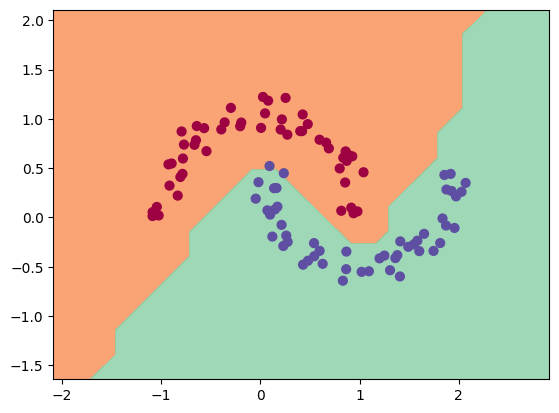

In [15]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs=torch.tensor(Xmesh).float()
scores=model(inputs)

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

Como pueden observar, el entrenamiento se ha desarrollado correctamente y hemos logrado una buena separación de los datos.
